# Adaptive link-percolation: 2-core data collapse for $\bar{\nu}$

Goal: test which $\bar{\nu}$ gives the cleanest finite-size scaling collapse using the **adaptive** data in `link_percolation/adaptive/`.

Assumptions (fixed):
- Critical threshold: $p_c = 0.5095205748$
- Exponent ratio: $\beta/\bar{\nu} = 2/3$

Order parameter: relative 2-core size
\[
P_2(p, N) = |C_2|/N
\]
where `|C2|` is taken from the `core_mean` column of the averaged `LR_LR_*.dat` files.

Data-collapse plot (linear-linear axes, using a symmetric window $|p-p_c| \le \Delta p$ so the x-axis can be negative for $p>p_c$):
\[
P_2\,N^{\beta/\bar{\nu}} \;\;\text{vs}\;\; (p_c - p)\,N^{1/\bar{\nu}}
\]

Important detail: we compute the actual removed-edge fraction as
\[
p = 1 - \frac{\texttt{edges\_remaining}}{M}
\]
using `M` from the file header (`# N=... M=...`). This matches the discrete rounding used in the simulation output.


In [1]:
from __future__ import annotations

from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for candidate in [start, *start.parents]:
        if (candidate / 'link_percolation').is_dir():
            return candidate
    raise FileNotFoundError('Could not find repo root containing link_percolation/')


def _parse_n_c_from_name(path: Path) -> tuple[int | None, float | None]:
    n_match = re.search(r'_N(\d+)', path.name)
    c_match = re.search(r'_c([0-9]+(?:\.[0-9]+)?)', path.name)
    n = int(n_match.group(1)) if n_match else None
    c = float(c_match.group(1)) if c_match else None
    return n, c


def parse_n_m_from_header_or_name(path: Path) -> tuple[int, int]:
    # Preferred: header line like '# N=524288 M=1048576'.
    n = None
    m = None
    with path.open() as fh:
        for line in fh:
            if not line.startswith('#'):
                break
            match = re.search(r'\bN=(\d+)\s+M=(\d+)\b', line)
            if match:
                n = int(match.group(1))
                m = int(match.group(2))
                break

    if n is not None and m is not None:
        return n, m

    # Fallback for header-less files: parse N and c from filename and reconstruct M for ER.
    n2, c2 = _parse_n_c_from_name(path)
    if n2 is None or c2 is None:
        raise ValueError(f'Could not parse N/M header and cannot reconstruct from filename: {path}')
    m2 = int(round(c2 * n2 / 2.0))
    return n2, m2


AVERAGED_COLS = [
    'edges_remaining',
    'frac_removed',
    'gc_mean',
    'gc_std',
    'small_mean',
    'small_std',
    'comp_mean',
    'comp_std',
    'cycles_mean',
    'cycles_std',
    'lambda1_mean',
    'lambda1_std',
    'core_mean',
    'core_std',
]


def read_averaged_lr_file(path: Path) -> pd.DataFrame:
    n, m = parse_n_m_from_header_or_name(path)
    df = pd.read_csv(
        path,
        comment='#',
        sep=r'\s+',
        header=None,
        names=AVERAGED_COLS,
        engine='python',
        on_bad_lines='skip',
    )
    if df.empty:
        raise ValueError(f'No data rows parsed from {path}')

    df = df.dropna(subset=['edges_remaining', 'core_mean']).copy()
    df['edges_remaining'] = df['edges_remaining'].astype(int)

    df['N'] = n
    df['M'] = m

    # Actual removed-edge fraction used by the output (accounts for integer rounding).
    df['p'] = 1.0 - df['edges_remaining'] / float(m)

    # Order parameter: relative 2-core size.
    df['P2'] = df['core_mean'] / float(n)
    return df


def downsample_for_plot(df: pd.DataFrame, max_points: int = 2000) -> pd.DataFrame:
    # Return a view of df with at most max_points rows (uniform stride).
    if len(df) <= max_points:
        return df
    step = int(np.ceil(len(df) / max_points))
    return df.iloc[::step].copy()


In [3]:
ROOT = find_repo_root()
DATA_DIR = ROOT / "link_percolation" / "adaptive"

# Averaged files are named like: LR_LR_ER_N1024_c4.00_L0_Mg10000_Mr1.dat
paths = sorted(
    p
    for p in DATA_DIR.glob("LR_LR_ER_N*_c*.dat")
    if ("EBE" not in p.name and not p.name.startswith("stats_"))
)

if not paths:
    raise FileNotFoundError(f"No averaged LR_LR files found in {DATA_DIR}")

by_N: dict[int, pd.DataFrame] = {}
for path in paths:
    df = read_averaged_lr_file(path)
    n = int(df["N"].iloc[0])
    by_N[n] = df

Ns = sorted(by_N)
print(f"Loaded {len(Ns)} system sizes from {DATA_DIR}")
print("N values:", Ns)


Loaded 11 system sizes from /nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive
N values: [8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608]


Loaded 11 system sizes from /nfs/nfs2/home/hanlsun/global_removal/link_percolation/adaptive
N values: [8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608]


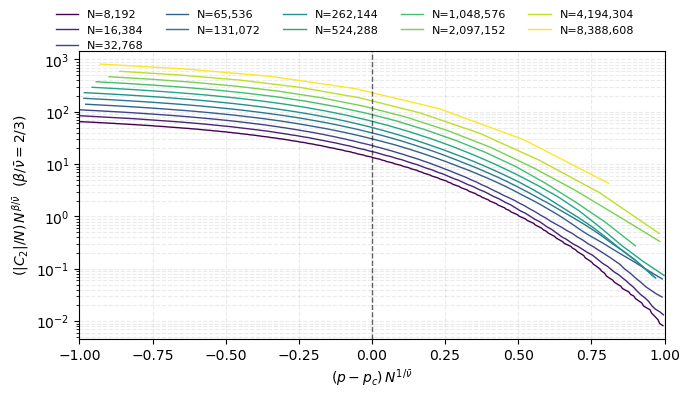

In [4]:
# Adaptive removal: 2-core data collapse

PC = 0.5095205748
BETA_OVER_NUBAR = 2 / 3
NUBAR = 2.0

X_MAX = 1.0  # keep points with |x| <= X_MAX, where x=(p-p_c)N^{1/nubar}

DATA_DIR = ROOT / "link_percolation" / "adaptive"

# Averaged files are named like: LR_LR_ER_N1024_c4.00_L0_Mg1000_Mr10.dat
paths = sorted(
    p
    for p in DATA_DIR.glob("LR_LR_ER_N*_c*.dat")
    if ("EBE" not in p.name and not p.name.startswith("stats_"))
)

if not paths:
    raise FileNotFoundError(f"No averaged LR_LR files found in {DATA_DIR}")

by_N: dict[int, pd.DataFrame] = {}
for path in paths:
    df = read_averaged_lr_file(path)
    n = int(df["N"].iloc[0])
    by_N[n] = df

Ns = sorted(by_N)
print(f"Loaded {len(Ns)} system sizes from {DATA_DIR}")
print("N values:", Ns)


def scaled_xy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    n = int(df["N"].iloc[0])
    p = df["p"].to_numpy(dtype=float)
    P2 = df["P2"].to_numpy(dtype=float)

    X = (p - PC) * (n ** (1.0 / NUBAR))
    mask = np.abs(X) <= X_MAX

    # Always include the sampled point closest to p_c.
    mask[int(np.argmin(np.abs(p - PC)))] = True

    x = X[mask]
    y = P2[mask] * (n ** BETA_OVER_NUBAR)

    finite = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x = x[finite]
    y = y[finite]

    order = np.argsort(x)
    return x[order], y[order]


colors = plt.cm.viridis(np.linspace(0, 1, len(Ns)))

fig, ax = plt.subplots(figsize=(7, 4))
for color, n in zip(colors, Ns):
    x, y = scaled_xy(by_N[n])
    if len(x) == 0:
        continue
    ax.plot(x, y, ms=3, lw=1, color=color, label=f"N={n:,}")

ax.axvline(0, color="k", ls="--", lw=1, alpha=0.6)
ax.set_xlim(-X_MAX, X_MAX)
ax.set_yscale("log")
# ax.set_title(r"Adaptive bond percolation: 2-core data collapse ($\bar{\nu}=3$)")
ax.set_xlabel(r"$(p - p_c)\,N^{1/\bar{\nu}}$")
ax.set_ylabel(r"$(|C_2|/N)\,N^{\beta/\bar{\nu}}$  ($\beta/\bar{\nu}=2/3$)")
ax.grid(True, which="both", ls="--", alpha=0.25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5, fontsize=8, frameon=False)
# fig.suptitle(
#     f"ADAPTIVE bond percolation: 2-core collapse | p_c={PC} | |x| <= {X_MAX}",
#     y=1.12,
# )
fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


pc(N) from EBE core_p_star:
  N=8,192: pc(N)=0.50910219 (LR_EBE_LR_ER_N8192_c4.00_L0_Mg10000_Mr1.dat)
  N=16,384: pc(N)=0.50927490 (LR_EBE_LR_ER_N16384_c4.00_L0_Mg10000_Mr1.dat)
  N=32,768: pc(N)=0.50939874 (LR_EBE_LR_ER_N32768_c4.00_L0_Mg10000_Mr1.dat)
  N=65,536: pc(N)=0.50948483 (LR_EBE_LR_ER_N65536_c4.00_L0_Mg10000_Mr1.dat)
  N=131,072: pc(N)=0.50951169 (LR_EBE_LR_ER_N131072_c4.00_L0_Mg10000_Mr1.dat)
  N=262,144: pc(N)=0.50950962 (LR_EBE_LR_ER_N262144_c4.00_L0_Mg10000_Mr1.dat)
  N=524,288: pc(N)=0.50951501 (LR_EBE_LR_ER_N524288_c4.00_L0_Mg10000_Mr1.dat)
  N=1,048,576: pc(N)=0.50951747 (LR_EBE_LR_ER_N1048576_c4.00_L0_Mg10000_Mr1.dat)
  N=2,097,152: pc(N)=0.50951334 (LR_EBE_LR_ER_N2097152_c4.00_L0_Mg10000_Mr1.dat)
  N=4,194,304: pc(N)=0.50951801 (LR_EBE_LR_ER_N4194304_c4.00_L0_Mg10000_Mr1.dat)
  N=8,388,608: pc(N)=0.50952160 (LR_EBE_LR_ER_N8388608_c4.00_L0_Mg10000_Mr1.dat)


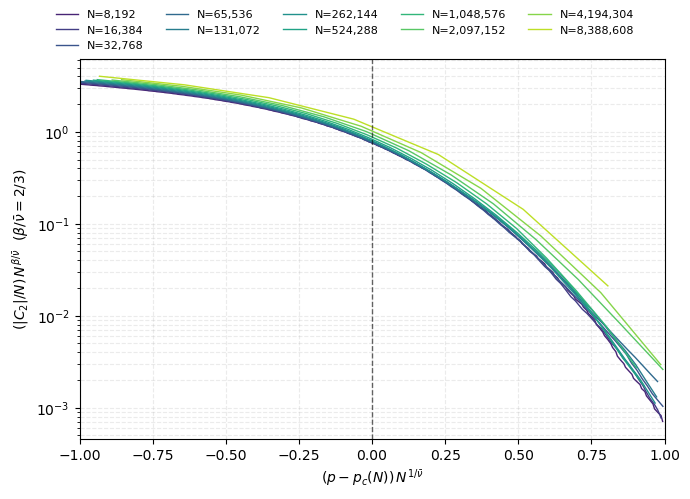

In [5]:
# Adaptive removal: 2-core data collapse using size-dependent pc(N)
# pc(N) is estimated from the EBE file as mean(core_p_star) for that N.
# BETA_OVER_NUBAR = 2 / 3
# NUBAR = 2.0
# X_MAX = 2.0
EBE_DIR = ROOT / 'link_percolation' / 'adaptive'
EBE_PATHS = sorted(p for p in EBE_DIR.glob('LR_EBE_LR_ER_N*_c*.dat') if not p.name.startswith('stats_'))


def _parse_total_runs_from_name(path: Path) -> int:
    mg = re.search(r'_Mg(\d+)_', path.name)
    mr = re.search(r'_Mr(\d+)', path.name)
    if not mg or not mr:
        return -1
    return int(mg.group(1)) * int(mr.group(1))


def _parse_N_from_ebe_header_or_name(path: Path) -> int:
    with path.open() as fh:
        for line in fh:
            if not line.startswith('#'):
                break
            m = re.search(r'\bN=(\d+)\b', line)
            if m:
                return int(m.group(1))
    m = re.search(r'_N(\d+)', path.name)
    if not m:
        raise ValueError(f'Could not parse N from {path.name}')
    return int(m.group(1))


def estimate_pcN_from_ebe(path: Path) -> float:
    # Column 25 in EBE is core_p_star. 0-based -> 24.
    col = pd.read_csv(
        path,
        comment='#',
        sep=r'\s+',
        header=None,
        usecols=[24],
        engine='python',
        on_bad_lines='skip',
    ).iloc[:, 0]
    col = col.dropna()
    if col.empty:
        raise ValueError(f'No core_p_star values parsed from {path.name}')
    return float(col.mean())


best_ebe_by_N: dict[int, Path] = {}
for p in EBE_PATHS:
    n = _parse_N_from_ebe_header_or_name(p)
    cur = best_ebe_by_N.get(n)
    if cur is None or _parse_total_runs_from_name(p) > _parse_total_runs_from_name(cur):
        best_ebe_by_N[n] = p

pc_by_N: dict[int, float] = {}
for n, p in sorted(best_ebe_by_N.items()):
    pc_by_N[n] = estimate_pcN_from_ebe(p)

print('pc(N) from EBE core_p_star:')
for n in sorted(pc_by_N):
    print(f'  N={n:,}: pc(N)={pc_by_N[n]:.8f} ({best_ebe_by_N[n].name})')


def scaled_xy_pcN(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    n = int(df['N'].iloc[0])
    pcN = pc_by_N.get(n)
    if pcN is None:
        return np.array([]), np.array([])

    p = df['p'].to_numpy(dtype=float)
    P2 = df['P2'].to_numpy(dtype=float)

    X = (p - pcN) * (n ** (1.0 / NUBAR))
    mask = np.abs(X) <= X_MAX

    idx = int(np.argmin(np.abs(p - pcN)))
    mask[idx] = True

    x = X[mask]
    y = P2[mask] * (n ** (BETA_OVER_NUBAR / NUBAR))
    y = np.where(y > 0, y, np.nan)

    keep = np.isfinite(x) & np.isfinite(y)
    return x[keep], y[keep]


fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(Ns)))

for color, n in zip(colors, Ns):
    df = by_N[n]
    x, y = scaled_xy_pcN(df)
    if len(x) == 0:
        continue
    ax.plot(x, y, ms=3, lw=1, color=color, label=f'N={n:,}')

ax.axvline(0, color='k', ls='--', lw=1, alpha=0.6)
ax.set_xlim(-X_MAX, X_MAX)
ax.set_yscale('log')
ax.set_xlabel(r'$(p - p_c(N))\,N^{1/\bar{\nu}}$')
ax.set_ylabel(r'$(|C_2|/N)\,N^{\beta/\bar{\nu}}$  ($\beta/\bar{\nu}=2/3$)')
ax.grid(True, which='both', ls='--', alpha=0.25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=8, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Loaded 8 system sizes from /nfs/nfs2/home/hanlsun/global_removal/link_percolation/random
N values: [8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]


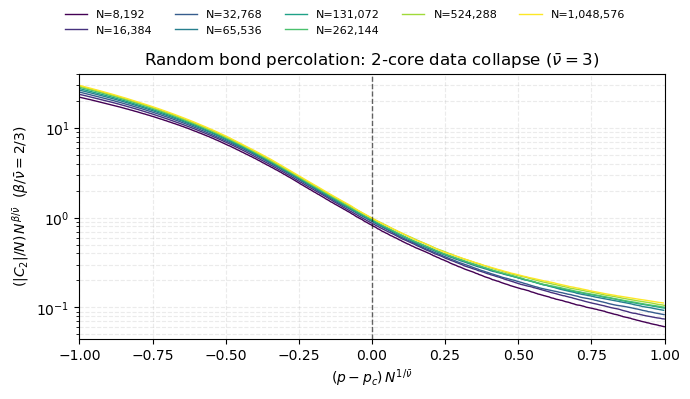

In [6]:
# Random bond percolation (standard): 2-core data collapse (known exponents).

PC_RANDOM = 0.75
NUBAR_RANDOM = 3
BETA_OVER_NUBAR_RANDOM = 2 / 3

X_MAX_RANDOM = 1.0  # keep points with |x| <= X_MAX_RANDOM, where x=(p-p_c)N^{1/nubar}

DATA_DIR_RANDOM = ROOT / "link_percolation" / "random"

# Averaged files are named like: LR_LR_ER_N1024_c4.00_L0_Mg1000_Mr10.dat
paths_random = sorted(
    p
    for p in DATA_DIR_RANDOM.glob("LR_LR_ER_N*_c*.dat")
    if ("EBE" not in p.name and not p.name.startswith("stats_"))
)

if not paths_random:
    raise FileNotFoundError(f"No averaged LR_LR files found in {DATA_DIR_RANDOM}")

by_N_random: dict[int, pd.DataFrame] = {}
for path in paths_random:
    df = read_averaged_lr_file(path)
    n = int(df["N"].iloc[0])
    by_N_random[n] = df

Ns_random = sorted(by_N_random)
print(f"Loaded {len(Ns_random)} system sizes from {DATA_DIR_RANDOM}")
print("N values:", Ns_random)


def scaled_xy_random(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    n = int(df["N"].iloc[0])
    p = df["p"].to_numpy(dtype=float)
    P2 = df["P2"].to_numpy(dtype=float)

    X = (p - PC_RANDOM) * (n ** (1.0 / NUBAR_RANDOM))
    mask = np.abs(X) <= X_MAX_RANDOM

    # Always include the sampled point closest to p_c.
    mask[int(np.argmin(np.abs(p - PC_RANDOM)))] = True

    x = X[mask]
    y = P2[mask] * (n ** BETA_OVER_NUBAR_RANDOM)

    finite = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x = x[finite]
    y = y[finite]

    order = np.argsort(x)
    return x[order], y[order]


colors_random = plt.cm.viridis(np.linspace(0, 1, len(Ns_random)))

fig, ax = plt.subplots(figsize=(7, 4))
for color, n in zip(colors_random, Ns_random):
    x, y = scaled_xy_random(by_N_random[n])
    if len(x) == 0:
        continue
    ax.plot(x, y, ms=3, lw=1, color=color, label=f"N={n:,}")

ax.axvline(0, color="k", ls="--", lw=1, alpha=0.6)
ax.set_xlim(-X_MAX_RANDOM, X_MAX_RANDOM)
ax.set_yscale("log")
ax.set_title(r"Random bond percolation: 2-core data collapse ($\bar{\nu}=3$)")
ax.set_xlabel(r"$(p - p_c)\,N^{1/\bar{\nu}}$")
ax.set_ylabel(r"$(|C_2|/N)\,N^{\beta/\bar{\nu}}$  ($\beta/\bar{\nu}=2/3$)")
ax.grid(True, which="both", ls="--", alpha=0.25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5, fontsize=8, frameon=False)
# fig.suptitle(
#     f"Random bond percolation: 2-core collapse | p_c={PC_RANDOM} | |x| <= {X_MAX_RANDOM}",
#     y=1.12,
# )
fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
